In [129]:
directory = '/content/drive/MyDrive/Colab Notebooks/Mnist'
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [130]:
import torchvision
import torch

In [131]:
! pip install lightly
! pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [132]:
import os
import torch
import torch.nn as nn
import torchvision
import pytorch_lightning as pl
import lightly
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from PIL import Image
import numpy as np
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import os
import cv2
import random
%matplotlib inline
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg

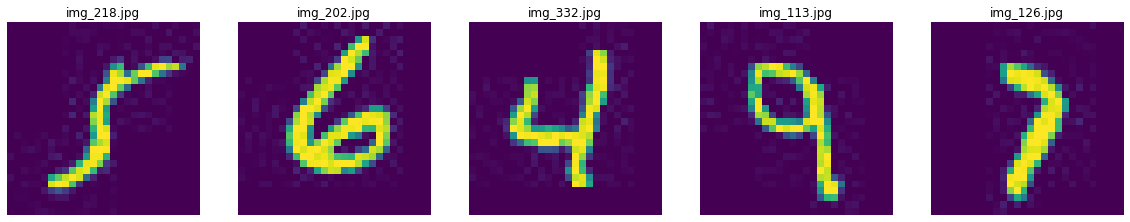

In [133]:
plt.figure(figsize=(20,20))
img_folder='/content/drive/MyDrive/Colab Notebooks/Mnist/train_all'
for i in range(5):
    file = random.choice(os.listdir(img_folder))
    image_path= os.path.join(img_folder, file)
    img=mpimg.imread(image_path,0)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.axis('off')
    plt.imshow(img)

In [134]:
import lightly.data as data

# the collate function applies random transforms to the input images
collate_fn = data.ImageCollateFunction(input_size=28, 
    # require invariance to flips and rotations
    hf_prob=0.5,
    vf_prob=0.5,
    rr_prob=0.5,
    # satellite images are all taken from the same height
    # so we use only slight random cropping
    min_scale=0.5,
    # use a weak color jitter for invariance w.r.t small color changes
    cj_prob=0.2,
    cj_bright=0.1,
    cj_contrast=0.1,
    cj_hue=0.1,
    cj_sat=0.1,
)

In [135]:
import torch

# create a dataset from your image folder
dataset = data.LightlyDataset(input_dir=img_folder)

# build a PyTorch dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,                # pass the dataset to the dataloader
    batch_size=256,         # a large batch size helps with the learning
    shuffle=True,           # shuffling is important!
    collate_fn=collate_fn)  # apply transformations to the input images

In [136]:
max_epochs = 200

In [137]:
from lightly.models.modules.heads import SimCLRProjectionHead
from lightly.loss import NTXentLoss


class SimCLRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # create a ResNet backbone and remove the classification head
        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        hidden_dim = resnet.fc.in_features
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)

        self.criterion = NTXentLoss()

    def forward(self, x):
        h = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(h)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optim, max_epochs
        )
        return [optim], [scheduler]

In [138]:
gpus = 1 if torch.cuda.is_available() else 0

model = SimCLRModel()
trainer = pl.Trainer(
    max_epochs=max_epochs, gpus=gpus, progress_bar_refresh_rate=100
)
trainer.fit(model, dataloader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=100)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | criterion       | NTXentLoss           | 0     
-------------------------

Training: 0it [00:00, ?it/s]

In [143]:
dataset.transform = torchvision.transforms.ToTensor()
dataloader = torch.utils.data.DataLoader(
    dataset,        # use the same dataset as before
    batch_size=1,   # we can use batch size 1 for inference
    shuffle=False,  # don't shuffle your data during inference
)
from torch import IntTensor

def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """

    embeddings = []
    tag=[]
    filen=[]
    with torch.no_grad():
        for img, label, fnames in dataloader:
          img = img.to(model.device)
          emb = model.backbone(img).flatten(start_dim=1)
          embeddings.append(emb)
          tensor = IntTensor.item(label)
          tag.append(tensor)
          string = ''.join(fnames)
          filen.append(string)

    embeddings = torch.cat(embeddings, 0)
    return embeddings, tag, filen


model.eval()
embeddings, tag, filen = generate_embeddings(model, dataloader)

In [144]:
print(type(embeddings))
print(embeddings)
import numpy as np
new_embeddings = np.array(embeddings)
print(type(new_embeddings))

<class 'torch.Tensor'>
tensor([[5.5244, 2.5181, 0.1833,  ..., 0.0000, 0.0000, 0.0000],
        [5.9665, 2.7337, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [6.9610, 2.4267, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [6.0697, 2.7714, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [5.9444, 2.6716, 0.1469,  ..., 0.0000, 0.0000, 0.0000],
        [6.2990, 2.8076, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
<class 'numpy.ndarray'>


In [145]:
from sklearn.decomposition import PCA
PCA = PCA(n_components=2)
two_D_embeddings = PCA.fit_transform(new_embeddings)

In [146]:
import os
from lightly.utils.io import save_embeddings
save_embeddings('/content/drive/MyDrive/Colab Notebooks/Mnist/embeddings.csv',two_D_embeddings,tag,filen)